<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/main/click-stream-data-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [30]:
clickStreamData = pd.read_excel("/content/sample_data/click_stream_new.xlsx", engine='openpyxl')

In [31]:
df = pd.DataFrame(clickStreamData)

In [32]:
df.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [33]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [ ]:
def clean_duplicate_path(path):
    # Remove consecutive duplicate events
    cleaned = []
    for event in path:
        if not cleaned or event != cleaned[-1]:
            cleaned.append(event)
    return cleaned

# Group by session_id and collect events in order
paths = df.groupby('session_id').apply(
    lambda x: clean_duplicate_path(x.sort_values('event_time')['event_name'].tolist())
)

# Filter only paths that end with BOOKING
booking_paths = paths[paths.apply(lambda x: x[-1] == 'BOOKING')]

# Get unique paths
unique_booking_paths = booking_paths.drop_duplicates()

<ipython-input-34-4baae5766a58>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  paths = df.groupby('session_id').apply(


In [ ]:
print(unique_booking_paths)

session_id
00001f29-3ede-4445-95f0-0178934e32ba    [HOMEPAGE, ADD_TO_CART, HOMEPAGE, CLICK, ITEM_...
0001971f-84ae-4bac-9612-366c5f241167    [HOMEPAGE, SEARCH, ADD_TO_CART, SCROLL, ADD_PR...
000288dc-e7cf-44b9-9f2d-270015fd83c6    [HOMEPAGE, ITEM_DETAIL, ADD_TO_CART, SEARCH, C...
0002ad9d-3c59-4c9c-b6dc-ae6a561ef718             [HOMEPAGE, SCROLL, ADD_TO_CART, BOOKING]
00049358-f228-48ad-b0f2-37d92cc93c0c                     [HOMEPAGE, ADD_TO_CART, BOOKING]
                                                              ...                        
fff48397-a528-4c4f-abfc-71402e57461a    [HOMEPAGE, SEARCH, ADD_TO_CART, SEARCH, ADD_PR...
fff4870b-f0e8-4563-ad10-1e5f6ef8c13f    [HOMEPAGE, ADD_TO_CART, CLICK, ADD_PROMO, SCRO...
fff9768b-2039-46be-8bcd-abe47d181cdb    [HOMEPAGE, ADD_TO_CART, CLICK, ADD_TO_CART, SE...
fffab223-134d-4054-875e-653d50de8667    [HOMEPAGE, PROMO_PAGE, ADD_TO_CART, CLICK, HOM...
fffc91d9-5189-4a52-8efa-a8aef79800ab    [HOMEPAGE, SEARCH, ADD_TO_CART, SEARCH, ADD_PR...

In [ ]:
##preparing transition map
transitions = defaultdict(lambda: defaultdict(int))

for path in unique_booking_paths:
    for i in range(len(path) - 1):
        from_event = path[i]
        to_event = path[i + 1]
        transitions[from_event][to_event] += 1

print("\nRaw Transition Counts:")
for from_event, to_events in transitions.items():
    print(f"{from_event}: {dict(to_events)}")


Raw Transition Counts:
HOMEPAGE: {'ADD_TO_CART': 23699, 'CLICK': 22426, 'SEARCH': 11176, 'ITEM_DETAIL': 10779, 'SCROLL': 14895, 'BOOKING': 4542, 'PROMO_PAGE': 5013, 'ADD_PROMO': 2170}
ADD_TO_CART: {'HOMEPAGE': 8037, 'SCROLL': 11008, 'SEARCH': 8102, 'BOOKING': 2151, 'ITEM_DETAIL': 8543, 'CLICK': 16884, 'ADD_PROMO': 3486, 'PROMO_PAGE': 4118}
CLICK: {'ITEM_DETAIL': 17007, 'SEARCH': 17746, 'SCROLL': 23688, 'HOMEPAGE': 17537, 'BOOKING': 9153, 'PROMO_PAGE': 7984, 'ADD_TO_CART': 13114, 'ADD_PROMO': 4528}
ITEM_DETAIL: {'SCROLL': 11265, 'CLICK': 16963, 'ADD_TO_CART': 6653, 'SEARCH': 8417, 'PROMO_PAGE': 3565, 'HOMEPAGE': 8439, 'ADD_PROMO': 1890, 'BOOKING': 4511}
SCROLL: {'BOOKING': 6223, 'ADD_PROMO': 2961, 'CLICK': 23823, 'ITEM_DETAIL': 11102, 'SEARCH': 11813, 'HOMEPAGE': 11633, 'ADD_TO_CART': 8539, 'PROMO_PAGE': 5187}
SEARCH: {'ADD_TO_CART': 6081, 'SCROLL': 11713, 'CLICK': 17729, 'HOMEPAGE': 8726, 'PROMO_PAGE': 3879, 'ITEM_DETAIL': 8455, 'BOOKING': 4619, 'ADD_PROMO': 2162}
ADD_PROMO: {'ITEM_DE

In [ ]:
# Convert counts to probabilities
prob_matrix = defaultdict(dict)

for from_event, to_events in transitions.items():
    total = sum(to_events.values())
    for to_event, count in to_events.items():
        prob_matrix[from_event][to_event] = count / total

print("\nProbability Matrix:")
for from_event, probs in prob_matrix.items():
    print(f"{from_event}: {probs}")


Probability Matrix:
HOMEPAGE: {'ADD_TO_CART': 0.2502534318901795, 'CLICK': 0.23681098204857445, 'SEARCH': 0.11801478352692714, 'ITEM_DETAIL': 0.11382259767687435, 'SCROLL': 0.15728616684266103, 'BOOKING': 0.047961985216473074, 'PROMO_PAGE': 0.05293558606124604, 'ADD_PROMO': 0.022914466737064414}
ADD_TO_CART: {'HOMEPAGE': 0.12894479295352082, 'SCROLL': 0.17661120826581528, 'SEARCH': 0.12998764620000322, 'BOOKING': 0.034510420510516775, 'ITEM_DETAIL': 0.13706300437998364, 'CLICK': 0.270885141747822, 'ADD_PROMO': 0.0559290218036548, 'PROMO_PAGE': 0.06606876413868344}
CLICK: {'ITEM_DETAIL': 0.15355237140767627, 'SEARCH': 0.16022463591466002, 'SCROLL': 0.21387361521167964, 'HOMEPAGE': 0.1583376220013182, 'BOOKING': 0.08264037487472575, 'PROMO_PAGE': 0.07208573724459853, 'ADD_TO_CART': 0.1184033514811705, 'ADD_PROMO': 0.04088229186417111}
ITEM_DETAIL: {'SCROLL': 0.18256810851984506, 'CLICK': 0.27491369949597266, 'ADD_TO_CART': 0.10782295836507139, 'SEARCH': 0.13641151969920426, 'PROMO_PAGE'

In [ ]:

# Convert to DataFrame
all_events = sorted(set(df["event_name"]))
prob_df = pd.DataFrame(index=all_events, columns=all_events).fillna(0.0)
for from_event, probs in prob_matrix.items():
    for to_event, prob in probs.items():
        prob_df.loc[from_event, to_event] = prob

<ipython-input-41-ade759008e0d>:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prob_df = pd.DataFrame(index=all_events, columns=all_events).fillna(0.0)


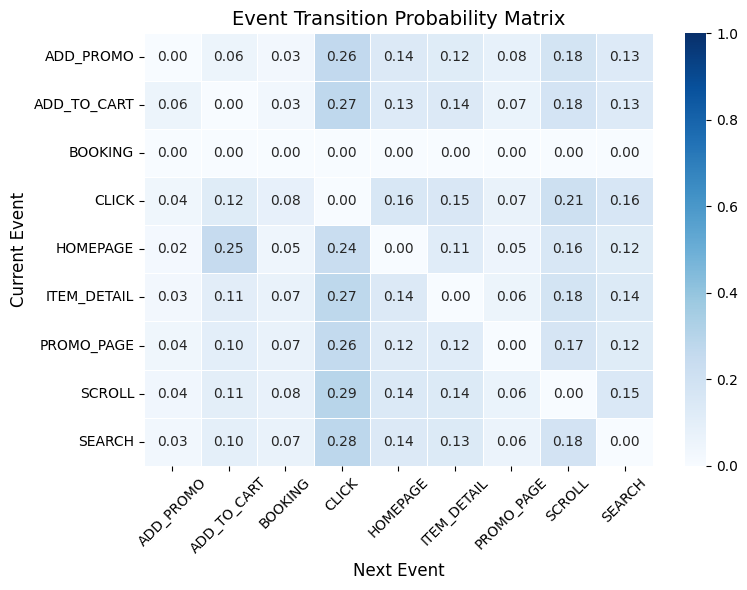

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    prob_df,
    annot=True,            # Show probabilities in cells
    fmt=".2f",            # Format as 2 decimal places
    cmap="Blues",         # Color scheme (Blues, YlOrRd, etc.)
    linewidths=0.5,       # Add grid lines
    cbar=True,            # Show color bar
    vmin=0, vmax=1        # Fix scale between 0 and 1
)

plt.title("Event Transition Probability Matrix", fontsize=14)
plt.xlabel("Next Event", fontsize=12)
plt.ylabel("Current Event", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Get sessions with BOOKING events
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].unique()

# Filter original data to only include these sessions
conversion_data = df[df['session_id'].isin(booking_sessions)]

# Group by traffic_source and count bookings
channel_conversions = conversion_data['traffic_source'].value_counts().reset_index()
channel_conversions.columns = ['traffic_source', 'bookings']

In [ ]:
# Count total sessions per channel
total_sessions = df.groupby('traffic_source')['session_id'].nunique().reset_index()
total_sessions.columns = ['traffic_source', 'total_sessions']

# Merge with bookings data
conversion_rates = pd.merge(channel_conversions, total_sessions, on='traffic_source')

# Calculate conversion rate
conversion_rates['conversion_rate'] = (conversion_rates['bookings'] / conversion_rates['total_sessions']) * 100  # as percentage

In [ ]:
conversion_rates = conversion_rates.sort_values('conversion_rate', ascending=False)
print(conversion_rates)

  traffic_source  bookings  total_sessions  conversion_rate
1            WEB    104923            6441      1628.986182
0         MOBILE    939214           58105      1616.408226


<ipython-input-46-a0f93471169d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


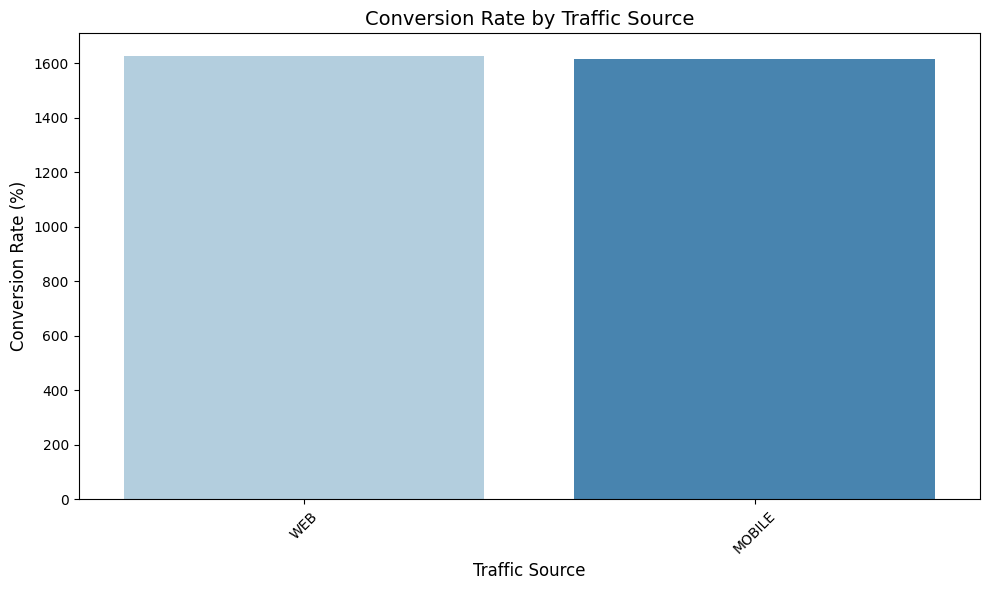

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=conversion_rates,
    x='traffic_source',
    y='conversion_rate',
    palette='Blues'
)
plt.title('Conversion Rate by Traffic Source', fontsize=14)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Conversion Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Get session_ids where BOOKING occurred
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].unique()

# Filter the original DataFrame to only these sessions
booking_journeys = df[df['session_id'].isin(booking_sessions)]

In [ ]:
def get_last_touch_point(session_df):
    session_df = session_df.sort_values('event_time')  # Sort chronologically
    events = session_df['event_name'].tolist()
    if 'BOOKING' in events:
        booking_index = events.index('BOOKING')
        return events[booking_index - 1] if booking_index > 0 else None
    return None

# Group by session_id and apply the function
last_touch_points = booking_journeys.groupby('session_id').apply(get_last_touch_point).reset_index()
last_touch_points.columns = ['session_id', 'last_touch_event']

<ipython-input-48-ec6a4d29528f>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_touch_points = booking_journeys.groupby('session_id').apply(get_last_touch_point).reset_index()


In [ ]:
last_touch_counts = last_touch_points['last_touch_event'].value_counts().reset_index()
last_touch_counts.columns = ['last_touch_event', 'count']

# Calculate percentage
last_touch_counts['percentage'] = (last_touch_counts['count'] / last_touch_counts['count'].sum()) * 100
print(last_touch_counts)

  last_touch_event  count  percentage
0            CLICK  16102   25.107591
1           SCROLL  10469   16.324144
2      ADD_TO_CART   7842   12.227905
3           SEARCH   7802   12.165534
4      ITEM_DETAIL   7749   12.082892
5         HOMEPAGE   7692   11.994012
6       PROMO_PAGE   3456    5.388885
7        ADD_PROMO   3020    4.709038


<ipython-input-50-269bc7e64cc7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


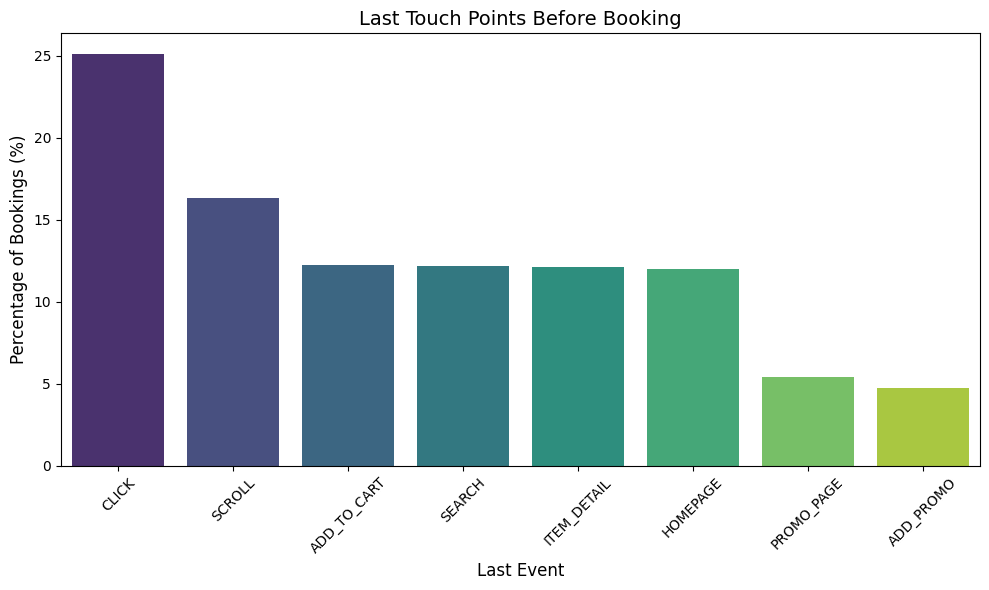

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=last_touch_counts,
    x='last_touch_event',
    y='percentage',
    palette='viridis'
)
plt.title('Last Touch Points Before Booking', fontsize=14)
plt.xlabel('Last Event', fontsize=12)
plt.ylabel('Percentage of Bookings (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
!pip install lifelines


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=706b97593e5d9c292e592a7794084435ae9043794cb6abe3549bbcfa81a82586
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [35]:
from lifelines import KaplanMeierFitter

In [84]:
import pandas as pd

#  Prepare data
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(['session_id', 'event_time'])
df['event_date'] = df['event_time'].dt.date

# Enhanced session calculation
def calculate_daily_sessions(group):
    daily_sessions = group.groupby('event_date').agg(
        session_start=('event_time', 'min'),
        session_end=('event_time', 'max'),
        event_count=('event_time', 'count'),
        events=('event_name', list)
    )
    daily_sessions['duration_min'] = (daily_sessions['session_end'] -
                                    daily_sessions['session_start']).dt.total_seconds() / 60
    return daily_sessions

#  Get booking details
booking_details = df[df['event_name'] == 'BOOKING'][['session_id', 'event_time', 'event_metadata']]
booking_details = booking_details.rename(columns={'event_time': 'booking_time'})

# Create comprehensive session info
session_info = (
    df.groupby('session_id')
    .apply(calculate_daily_sessions)
    .reset_index()
    .merge(
        booking_details,
        on='session_id',
        how='left'
    )
    .assign(
        converted=lambda x: ~x['booking_time'].isna(),
        time_to_convert=lambda x: (x['booking_time'] - x['session_start']).dt.total_seconds() / 60
    )
)

# Final converted sessions with all details
converted_sessions = (
    session_info[session_info['converted']]
    .sort_values('time_to_convert')
    .reset_index(drop=True)
)

<ipython-input-84-4dac0e2940f5>:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(calculate_daily_sessions)


In [85]:
survival_data = (
    session_info
    .sort_values(['session_id', 'session_start'])
    .groupby('session_id')
    .first()
    .reset_index()
)

# For sessions that converted, use their time_to_convert
# For non-converting sessions, use their duration_min as censored observations
survival_data['T'] = survival_data.apply(
    lambda x: x['time_to_convert'] if x['converted'] else x['duration_min'],
    axis=1
)
survival_data['E'] = survival_data['converted'].astype(int)  # 1 if converted, 0 if censored

In [103]:
kmf = KaplanMeierFitter()
kmf.fit(survival_data['T'], event_observed=survival_data['E'])


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 64546 total observations, 414 right-censored observations>

In [102]:
# Get conversion probability at specific time points (in minutes)
time_points = [1, 5, 10, 15, 30, 60,120,200,300]
for t in time_points:
    survival_prob = kmf.predict(t)
    print(f"After {t} minutes:")
    print(f"  • Probability of NOT converting: {survival_prob:.1%}")
    print(f"  • Probability of converting: {1-survival_prob:.1%}\n")

After 1 minutes:
  • Probability of NOT converting: 99.9%
  • Probability of converting: 0.1%

After 5 minutes:
  • Probability of NOT converting: 99.5%
  • Probability of converting: 0.5%

After 10 minutes:
  • Probability of NOT converting: 99.1%
  • Probability of converting: 0.9%

After 15 minutes:
  • Probability of NOT converting: 98.7%
  • Probability of converting: 1.3%

After 30 minutes:
  • Probability of NOT converting: 97.6%
  • Probability of converting: 2.4%

After 60 minutes:
  • Probability of NOT converting: 95.7%
  • Probability of converting: 4.3%

After 120 minutes:
  • Probability of NOT converting: 92.8%
  • Probability of converting: 7.2%

After 200 minutes:
  • Probability of NOT converting: 89.5%
  • Probability of converting: 10.5%

After 300 minutes:
  • Probability of NOT converting: 85.8%
  • Probability of converting: 14.2%



In [105]:
median_time = kmf.median_survival_time_
print(f"Median conversion time: {median_time:.1f} minutes")

Median conversion time: 1875.8 minutes


<ipython-input-107-d6514b95c8c9>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right', frameon=True)
<ipython-input-107-d6514b95c8c9>:45: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


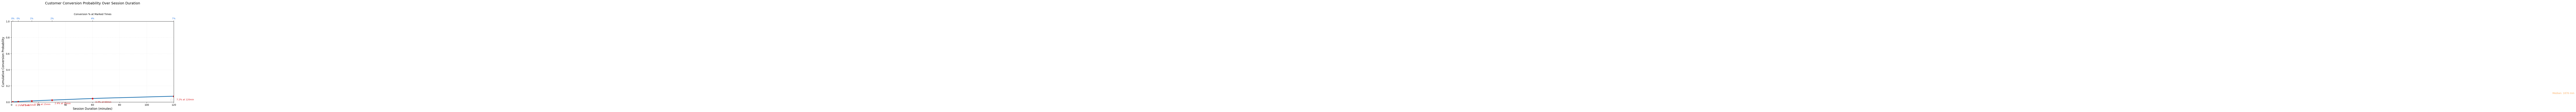

In [107]:


plt.figure(figsize=(12, 6))

conv_prob = 1 - kmf.survival_function_
plt.plot(conv_prob, color='#2c7bb6', linewidth=3,
         label=f'Conversion Probability (Final: {final_conversion_rate:.1%})')

key_times = [1, 5, 15, 30, 60, 120]  # Important time points to highlight
for t in key_times:
    if t <= kmf.timeline.max():
        prob = 1 - kmf.predict(t)
        plt.scatter(t, prob, color='#d7191c', zorder=5)
        plt.text(t+2, prob-0.05, f'{prob:.1%} at {t}min',
                fontsize=9, color='#d7191c')

# Add median conversion time
median_time = kmf.median_survival_time_
plt.axvline(median_time, color='#fdae61', linestyle='--', alpha=0.7)
plt.text(median_time+2, 0.1, f'Median: {median_time:.0f} min',
         color='#fdae61', fontsize=10)

# Add conversion probability bands
plt.fill_between(kmf.timeline,
                 (1 - kmf.confidence_interval_['KM_estimate_upper_0.95']),
                 (1 - kmf.confidence_interval_['KM_estimate_lower_0.95']),
                 color='#2c7bb6', alpha=0.2)

# Formatting
plt.title('Customer Conversion Probability Over Session Duration\n',
         fontsize=14, pad=20)
plt.xlabel('Session Duration (minutes)', fontsize=12)
plt.ylabel('Cumulative Conversion Probability', fontsize=12)
plt.ylim(0, 1)
plt.xlim(0, min(120, kmf.timeline.max()))  # Focus on first 120 minutes
plt.grid(True, which='both', linestyle=':', alpha=0.4)

# Add conversion velocity indicators
ax2 = plt.gca().twiny()
ax2.set_xlim(plt.gca().get_xlim())
ax2.set_xticks(key_times)
ax2.set_xticklabels([f'{1-kmf.predict(t):.0%}' for t in key_times],
                   fontsize=9, color='#2c7be6')
ax2.set_xlabel('Conversion % at Marked Times', fontsize=10, labelpad=10)

plt.legend(loc='lower right', frameon=True)
plt.tight_layout()
plt.show()